In [12]:
import numpy as np
from omfiles import OmFilePyReader

def read_om_point(path, lat, lon, time_index):
    # Build coordinate arrays manually
    lats = np.linspace(90, -90, 721)
    lons = np.linspace(0, 360 - 0.25, 1440)

    with OmFilePyReader(path) as reader:
        arr = reader[:]   # shape (721, 1440, 504)

        # Find nearest indices
        lat_idx = np.abs(lats - lat).argmin()
        lon_idx = np.abs(lons - lon).argmin()

        # Extract value
        value = arr[lat_idx, lon_idx, time_index]
        return float(value)


In [13]:
val = read_om_point(
    "data/chunk_968.om",
    lat=52.52,      # Berlin
    lon=13.41,
    time_index=100  # 100th hour in this chunk
)
print(val)


0.0


In [14]:
from omfiles import OmFilePyReader

with OmFilePyReader("data/chunk_968.om") as reader:
    print("Shape:", reader.shape)
    print("Dtype:", reader.dtype)
    print("Name:", reader.name)
    print("First slice stats:")
    arr = reader[:, :, 0]   # first time step
    print("  min:", arr.min(), "max:", arr.max(), "mean:", arr.mean())


Shape: [721, 1440, 504]
Dtype: float32
Name: 
First slice stats:
  min: 0.0 max: 27.8 mean: 0.099664636


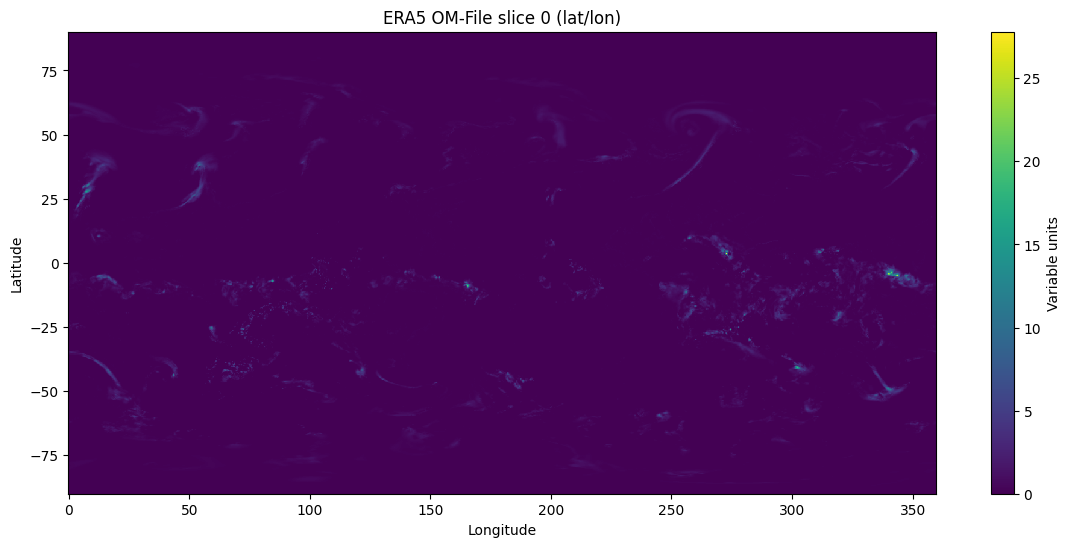

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from omfiles import OmFilePyReader

# ERA5 grid definition
lats = np.linspace(90, -90, 721)          # 0.25° resolution
lons = np.linspace(0, 360 - 0.25, 1440)   # 0.25° resolution

# Open OM-file
with OmFilePyReader("data/chunk_968.om") as reader:
    slice0 = reader[:, :, 0]   # first time step

# Plot with real coords
plt.figure(figsize=(14, 6))
im = plt.pcolormesh(lons, lats, slice0, cmap="viridis", shading="auto")
plt.colorbar(im, label="Variable units")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("ERA5 OM-File slice 0 (lat/lon)")
plt.show()


In [64]:
import os
import s3fs
from datetime import datetime

def download_era5_variable(variable: str, n_days: int, output_dir="era5_data"):
    """
    Download ERA5 OM-file chunks for a variable from today back N days.
    Files are stored in a subfolder named after the variable.

    Args:
        variable (str): ERA5 variable name (e.g. "temperature_2m", "precipitation")
        n_days (int): Number of days back from today
        output_dir (str): Base directory to store downloaded files

    Returns:
        list of str: Paths to downloaded files
    """
    fs = s3fs.S3FileSystem(anon=True, client_kwargs={'region_name': 'us-west-2'})
    bucket = f"openmeteo/data/copernicus_era5/{variable}/"

    # List all OM chunks for this variable
    files = [f for f in fs.ls(bucket) if f.endswith(".om")]

    # Get file info with last modified date
    file_infos = []
    for f in files:
        info = fs.info(f)
        mod_time = info["LastModified"]  # already datetime
        file_infos.append((f, mod_time))

    # Sort newest → oldest
    file_infos.sort(key=lambda x: x[1], reverse=True)

    # Each chunk ≈ 21 days → compute how many needed
    chunks_needed = (n_days // 21) + 1

    # Select required chunks
    selected = file_infos[:chunks_needed]

    # Create subfolder for this variable
    var_dir = os.path.join(output_dir, variable)
    os.makedirs(var_dir, exist_ok=True)
    local_paths = []

    for s3_path, mod_time in selected:
        filename = os.path.basename(s3_path)
        local_path = os.path.join(var_dir, filename)
        if not os.path.exists(local_path):
            print(f"Downloading {filename} (last modified {mod_time}) → {var_dir}")
            fs.get(s3_path, local_path)
        else:
            print(f"Already exists: {local_path}")
        local_paths.append(local_path)

    return local_paths


import os
import numpy as np
from omfiles import OmFilePyReader

def fetch_era5_point(variable: str, n_days: int, lat: float, lon: float, output_dir="era5_data"):
    """
    Read previously downloaded ERA5 OM-File chunks for a variable
    and fetch values at a specific coordinate.
    
    Args:
        variable (str): ERA5 variable name (e.g. "temperature_2m", "precipitation")
        n_days (int): Number of days back from today
        lat (float): Latitude in degrees (-90 to 90)
        lon (float): Longitude in degrees (-180 to 360; will auto-adjust if negative)
        output_dir (str): Base directory where OM files are stored
    
    Returns:
        np.ndarray: Time series values (hourly) for the requested period
    """
    # Directory where files for this variable are stored
    var_dir = os.path.join(output_dir, variable)
    if not os.path.exists(var_dir):
        raise FileNotFoundError(f"No local files found for variable '{variable}' in {var_dir}")
    
    # Collect all .om files for this variable
    files = [os.path.join(var_dir, f) for f in os.listdir(var_dir) if f.endswith(".om")]
    if not files:
        raise FileNotFoundError(f"No .om files found in {var_dir}")
    
    # Sort files by modification time (newest first, consistent with download order)
    files.sort(key=lambda f: os.path.getmtime(f), reverse=True)
    
    # Each chunk ≈ 21 days → compute how many needed
    chunks_needed = (n_days // 21) + 1
    selected = files[:chunks_needed]
    
    # Build ERA5 lat/lon grid
    if lon < 0:
        lon += 360
    lats = np.linspace(90, -90, 721)
    lons = np.linspace(0, 360 - 0.25, 1440)
    lat_idx = np.abs(lats - lat).argmin()
    lon_idx = np.abs(lons - lon).argmin()
    
    # Read values from selected files
    values = []
    for path in selected:
        with OmFilePyReader(path) as reader:
            arr = reader[:]  # (721, 1440, 504) = (lat, lon, time)
            ts = arr[lat_idx, lon_idx, :]
            values.append(ts)
    
    # Concatenate and trim to exactly N days
    series = np.concatenate(values)
    return series[-n_days * 24:]


# Example usage:
# Get last 30 days of ERA5 2m temperature
files = download_era5_variable("wind_gusts_10m", 30)
print("Downloaded:", files)



Downloaded: ['era5_data\\wind_gusts_10m\\chunk_968.om', 'era5_data\\wind_gusts_10m\\chunk_967.om']


In [18]:
import geopandas as gpd
from omfiles import OmFilePyReader
import numpy as np

# Load crop polygons
gdf = gpd.read_file("crop.geojson")

# ERA5 grid
lats = np.linspace(-90, 90, 721)             # 90 → -90
lons = np.linspace(0, 360 - 0.25, 1440)      # 0 → 359.75

def idw_interpolate_series(lat, lon, arr, lats, lons, radius=2, power=2):
    """
    IDW interpolation of a full time series at (lat, lon).
    
    Parameters
    ----------
    lat, lon : float
        Coordinates of point
    arr : np.ndarray
        ERA5 data cube (lat, lon, time)
    lats, lons : np.ndarray
        Coordinate arrays
    radius : int
        Search radius in grid cells
    power : int
        Power for inverse distance weighting
    
    Returns
    -------
    np.ndarray
        Interpolated time series (length = arr.shape[2])
    """
    if lon < 0:
        lon += 360

    # Find central grid indices
    i = np.abs(lats - lat).argmin()
    j = np.abs(lons - lon).argmin()

    # Extract neighborhood
    i0, i1 = max(i - radius, 0), min(i + radius, len(lats) - 1)
    j0, j1 = max(j - radius, 0), min(j + radius, len(lons) - 1)

    sub_lats = lats[i0:i1+1]
    sub_lons = lons[j0:j1+1]
    sub_arr = arr[i0:i1+1, j0:j1+1, :]   # shape: (nlat, nlon, time)

    # Flatten neighborhood
    grid_lat, grid_lon = np.meshgrid(sub_lats, sub_lons, indexing="ij")
    flat_lat = grid_lat.ravel()
    flat_lon = grid_lon.ravel()
    flat_vals = sub_arr.reshape(-1, sub_arr.shape[-1])

    # Compute distances
    dists = np.sqrt((flat_lat - lat)**2 + (flat_lon - lon)**2)
    dists[dists == 0] = 1e-6  # avoid zero division

    weights = 1.0 / (dists**power)
    weights = weights[:, np.newaxis]  # shape (npoints, 1)

    # Apply weights, ignoring NaNs
    mask = np.isfinite(flat_vals)
    weighted_vals = np.where(mask, flat_vals * weights, 0.0)
    weighted_weights = np.where(mask, weights, 0.0)

    series = np.sum(weighted_vals, axis=0) / np.sum(weighted_weights, axis=0)
    return series

# Open OM-file
with OmFilePyReader("era5_data/temperature_2m/chunk_968.om") as reader:
    arr = reader[:]  # (721, 1440, 504)

    wind_gust_values = []
    for idx, row in gdf.iterrows():
        centroid = row.geometry.centroid
        lat, lon = centroid.y, centroid.x

        series = idw_interpolate_series(lat, lon, arr, lats, lons, radius=3, power=2)
        wind_gust = float(np.nanmean(series))  # mean over 504 hours
        wind_gust_values.append(wind_gust)

# Add to GeoDataFrame
gdf["temperature_2m"] = wind_gust_values
gdf.to_file("crop_with_temperature_2m.geojson", driver="GeoJSON")


C:\Users\ferli\AppData\Local\Temp\ipykernel_29240\126258316.py:67: RuntimeWarning: invalid value encountered in divide
  series = np.sum(weighted_vals, axis=0) / np.sum(weighted_weights, axis=0)


# Get file and location

In [45]:
def get_day_indices(day, global_start, chunk_hours=504, base_dir="era5_data/temperature_2m"):
    """
    Given a date (year, month, day), return all (file, index) pairs for that day.

    Parameters
    ----------
    day : datetime.date or datetime.datetime
        The calendar day of interest.
    global_start : datetime.datetime
        First datetime in the ERA5 series.
    chunk_hours : int
        Hours per .om chunk (default 504).
    base_dir : str
        Directory of chunk files.

    Returns
    -------
    list of tuples
        Each tuple is (filepath, idx_in_chunk) for one of the 24 hours.
    """
    if isinstance(day, dt.datetime):
        day = day.date()

    start = dt.datetime.combine(day, dt.time(0, 0))
    indices = []
    for h in range(24):
        ts = start + dt.timedelta(hours=h)
        filepath, idx = get_chunk_and_index(ts, global_start,
                                            chunk_hours=chunk_hours,
                                            base_dir=base_dir)
        indices.append((filepath, idx))
    return indices


# Example usage:
global_start = dt.datetime(1970,1,1,0)   # adjust to match your dataset
day = dt.date(2025,9,11)

day_indices = get_day_indices(day, global_start)
for f, i in day_indices:
    print(f, i)


era5_data/temperature_2m\chunk_968.om 336
era5_data/temperature_2m\chunk_968.om 337
era5_data/temperature_2m\chunk_968.om 338
era5_data/temperature_2m\chunk_968.om 339
era5_data/temperature_2m\chunk_968.om 340
era5_data/temperature_2m\chunk_968.om 341
era5_data/temperature_2m\chunk_968.om 342
era5_data/temperature_2m\chunk_968.om 343
era5_data/temperature_2m\chunk_968.om 344
era5_data/temperature_2m\chunk_968.om 345
era5_data/temperature_2m\chunk_968.om 346
era5_data/temperature_2m\chunk_968.om 347
era5_data/temperature_2m\chunk_968.om 348
era5_data/temperature_2m\chunk_968.om 349
era5_data/temperature_2m\chunk_968.om 350
era5_data/temperature_2m\chunk_968.om 351
era5_data/temperature_2m\chunk_968.om 352
era5_data/temperature_2m\chunk_968.om 353
era5_data/temperature_2m\chunk_968.om 354
era5_data/temperature_2m\chunk_968.om 355
era5_data/temperature_2m\chunk_968.om 356
era5_data/temperature_2m\chunk_968.om 357
era5_data/temperature_2m\chunk_968.om 358
era5_data/temperature_2m\chunk_968

In [49]:
import os
import numpy as np
from omfiles import OmFilePyReader

def inspect_whole_chunk(path):
    """
    Inspect an entire OM-file, reporting NaN/valid counts per timestep.
    
    Parameters
    ----------
    path : str
        Path to the .om file
    """
    with OmFilePyReader(path) as reader:
        arr = reader[:]  # shape (721, 1440, 504)

    print(f"[INFO] File {os.path.basename(path)} shape={arr.shape}")
    print("Overall min/max:", np.nanmin(arr), np.nanmax(arr))
    print("Total valid:", np.isfinite(arr).sum(), " / ", arr.size)

    # Loop through each hour in the chunk
    for k in range(arr.shape[-1]):
        slice_k = arr[:, :, k]
        n_valid = np.isfinite(slice_k).sum()
        n_nan   = np.isnan(slice_k).sum()
        if k < 10 or k % 50 == 0 or k == arr.shape[-1]-1:  # print first 10, then every 50th, and last
            print(f"  t={k:03d}: valid={n_valid}, nan={n_nan}")
    
    return arr


In [60]:
import os
import glob
import datetime as dt

CHUNK_HOURS = 504  # 21 days

def _discover_chunk_ids(base_dir):
    files = glob.glob(os.path.join(base_dir, "chunk_*.om"))
    if not files:
        raise FileNotFoundError(f"No .om files found in {base_dir}")
    ids = sorted(int(os.path.basename(f).split("_")[1].split(".")[0]) for f in files)
    return ids[0], ids[-1]

def make_local_time_mapper(base_dir, anchor_day=None, chunk_hours=CHUNK_HOURS):
    """
    Build a mapper that uses YOUR LOCAL ARCHIVE as the timeline.
    We anchor so that `anchor_day` (default: today) == start of the LAST chunk.
    Then chunk numbering on disk (e.g. 904..968) maps cleanly to calendar dates.

    Returns:
      get_day_indices(day) -> list[(filepath, idx)]
      chunk_date_range_local(chunk_idx) -> (start_dt, end_dt)
    """
    first_id, last_id = _discover_chunk_ids(base_dir)
    if anchor_day is None:
        anchor_day = dt.date.today()

    # Anchor: 'anchor_day 00:00' is the START of the last chunk
    anchor_start = dt.datetime.combine(anchor_day, dt.time(0, 0))
    # This defines the local epoch (the datetime that would correspond to chunk_0 start)
    local_epoch = anchor_start - dt.timedelta(hours=last_id * chunk_hours)

    def get_day_indices(day):
        """Map a UTC day to 24 (file, idx) pairs under the local anchoring."""
        if isinstance(day, dt.datetime):
            day = day.date()
        start = dt.datetime.combine(day, dt.time(0, 0))
        offset_h = int((start - local_epoch).total_seconds() // 3600)

        out = []
        for h in range(24):
            t = offset_h + h
            chunk_idx = t // chunk_hours
            idx_in_chunk = t % chunk_hours
            fpath = os.path.join(base_dir, f"chunk_{chunk_idx}.om")
            out.append((fpath, idx_in_chunk))
        return out

    def chunk_date_range_local(chunk_idx):
        """Start/end datetimes of a given chunk under this local anchoring."""
        start = local_epoch + dt.timedelta(hours=chunk_idx * chunk_hours)
        end = start + dt.timedelta(hours=chunk_hours - 1)
        return start, end

    # Small sanity print (optional): where do first/last chunks fall?
    s_first, e_first = chunk_date_range_local(first_id)
    s_last,  e_last  = chunk_date_range_local(last_id)
    print(f"[LOCAL RANGE] chunk_{first_id} → {s_first} … {e_first}")
    print(f"[LOCAL RANGE] chunk_{last_id}  → {s_last} … {e_last}")

    return get_day_indices, chunk_date_range_local

# ---------- Example usage ----------
if __name__ == "__main__":
    base_dir = "era5_data/temperature_2m"

    # Build mapper so that TODAY (2025-09-11) starts the LAST chunk on disk.
    # This ensures 2025-09-11 maps to chunk_<last_id>. If last_id==968, you'll get 968.
    anchor_day = dt.date(2025, 9, 11)
    get_day_indices, chunk_range = make_local_time_mapper(base_dir, anchor_day=anchor_day)

    # Validate: map today
    today = dt.date(2025, 9, 11)
    pairs = get_day_indices(today)
    # Print unique chunk ids used and the first/last index
    used = [(os.path.basename(f), idx) for f, idx in pairs]
    print("Today mapping (file, idx):")
    for f, idx in used:
        print(f, idx)

    # Also show the day at the start of your first chunk to confirm alignment
    first_file_start, _ = chunk_range(int(os.path.basename(glob.glob(os.path.join(base_dir, 'chunk_*.om'))[0]).split("_")[1].split(".")[0]))
    print("First local chunk starts at:", first_file_start)


[LOCAL RANGE] chunk_967 → 2025-08-21 00:00:00 … 2025-09-10 23:00:00
[LOCAL RANGE] chunk_968  → 2025-09-11 00:00:00 … 2025-10-01 23:00:00
Today mapping (file, idx):
chunk_968.om 0
chunk_968.om 1
chunk_968.om 2
chunk_968.om 3
chunk_968.om 4
chunk_968.om 5
chunk_968.om 6
chunk_968.om 7
chunk_968.om 8
chunk_968.om 9
chunk_968.om 10
chunk_968.om 11
chunk_968.om 12
chunk_968.om 13
chunk_968.om 14
chunk_968.om 15
chunk_968.om 16
chunk_968.om 17
chunk_968.om 18
chunk_968.om 19
chunk_968.om 20
chunk_968.om 21
chunk_968.om 22
chunk_968.om 23
First local chunk starts at: 2025-08-21 00:00:00


In [59]:
day = dt.date(2025,9, 11)
fpath, idxs = date_to_chunk_indices(day, "era5_data/temperature_2m")
print("File:", fpath)
print("Indices:", idxs)


File: era5_data/temperature_2m\chunk_1160.om
Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [57]:
first_chunk = 904
true_start = dt.datetime(1959, 1, 1) + dt.timedelta(hours=first_chunk*504)
print("True archive start:", true_start)

True archive start: 2010-12-23 00:00:00


In [17]:
from omfiles import OmFilePyReader
import numpy as np

lats = np.linspace(90, -90, 721)
lons = np.linspace(0, 360 - 0.25, 1440)

lat, lon = 43.318, 11.331  # Siena

with OmFilePyReader("era5_data/temperature_2m/chunk_968.om") as reader:
    arr = reader[:]  # shape (721, 1440, 504)
    
    # Find nearest gridpoint
    i = np.abs(lats - lat).argmin()
    j = np.abs(lons - (lon if lon >= 0 else lon + 360)).argmin()
    
    series = arr[i, j, :]  # full 504-hour series
    print("Series length:", len(series))
    print("All values:", series)


Series length: 504
All values: [11.   11.05 11.2  11.25 11.2  11.2  11.25 11.35 11.4  11.4  11.15 11.3
 11.5  11.7  11.8  11.9  11.95 12.   11.95 11.9  11.85 11.75 11.95 11.95
 11.9  11.95 12.   12.1  12.15 12.2  12.25 12.25 12.   11.85 12.2  12.3
 12.15 12.3  11.9  11.55 11.25 11.45 11.55 11.65 11.7  11.75 11.1  11.2
 11.35 11.05 10.85 10.65 10.55 10.6  10.55 10.45 10.4  10.35  9.55  9.4
  9.65  9.9  10.05 10.05 10.1  10.25 10.45 10.6  10.9  11.25 11.65 11.85
 12.05 12.15 12.25 12.35 12.45 12.5  12.45 12.35 12.   11.8  11.65 11.6
 11.7  12.   11.9  11.55 11.7  11.6  11.7  11.6  11.35 11.25 11.3  11.2
 11.1  11.1  11.05 11.   10.95  9.6   8.65  8.7   9.05  9.25  9.3   9.25
  9.55  9.9  10.   10.05 10.2  10.35 10.35 10.45 10.75 11.   11.   10.6
 10.35  9.6  10.2   9.85  9.65  9.7   9.95 10.15 10.15 10.3  10.2  10.3
 10.35 10.45 10.45 10.5  10.6  10.7  10.85 11.   10.55  9.7   8.8   8.8
  8.75  8.4   8.3   8.6   9.15  9.55  9.3   8.95  9.    9.    8.45  8.45
  8.9   9.15  9.2   9.2   9.1

In [13]:
from omfiles import OmFilePyReader
from matplotlib.colors import TwoSlopeNorm

lats = np.linspace(90, -90, 721)
lons = np.linspace(0, 360 - 0.25, 1440)
import matplotlib.pyplot as plt

def plot_multiple_times(filepath, timesteps=None, cmap="coolwarm"):
    with OmFilePyReader(filepath) as reader:
        arr = reader[:]

    # If timesteps not provided, use all valid ones
    if timesteps is None:
        timesteps = range(arr.shape[2])

    # Global min/max for scaling
    vmin, vmax = np.nanpercentile(arr, [2, 98])

    # Force zero to be the center of colormap
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    nplots = len(timesteps)
    ncols = min(3, nplots)
    nrows = int(np.ceil(nplots / ncols))

    plt.figure(figsize=(5*ncols, 4*nrows))

    for i, t in enumerate(timesteps):
        sl = arr[:, :, t]
        if not np.any(np.isfinite(sl)):
            print(f"Skipping time {t} (all NaN)")
            continue

        sl = np.flipud(sl)
        lats_flipped = np.linspace(90, -90, sl.shape[0])

        ax = plt.subplot(nrows, ncols, i+1)
        im = ax.pcolormesh(
            lons, lats_flipped, sl,
            cmap=cmap, shading="auto", norm=norm
        )
        ax.set_title(f"t={t}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.colorbar(im, ax=plt.gcf().get_axes(), label="Temperature (°C)", orientation="vertical")
    plt.show()


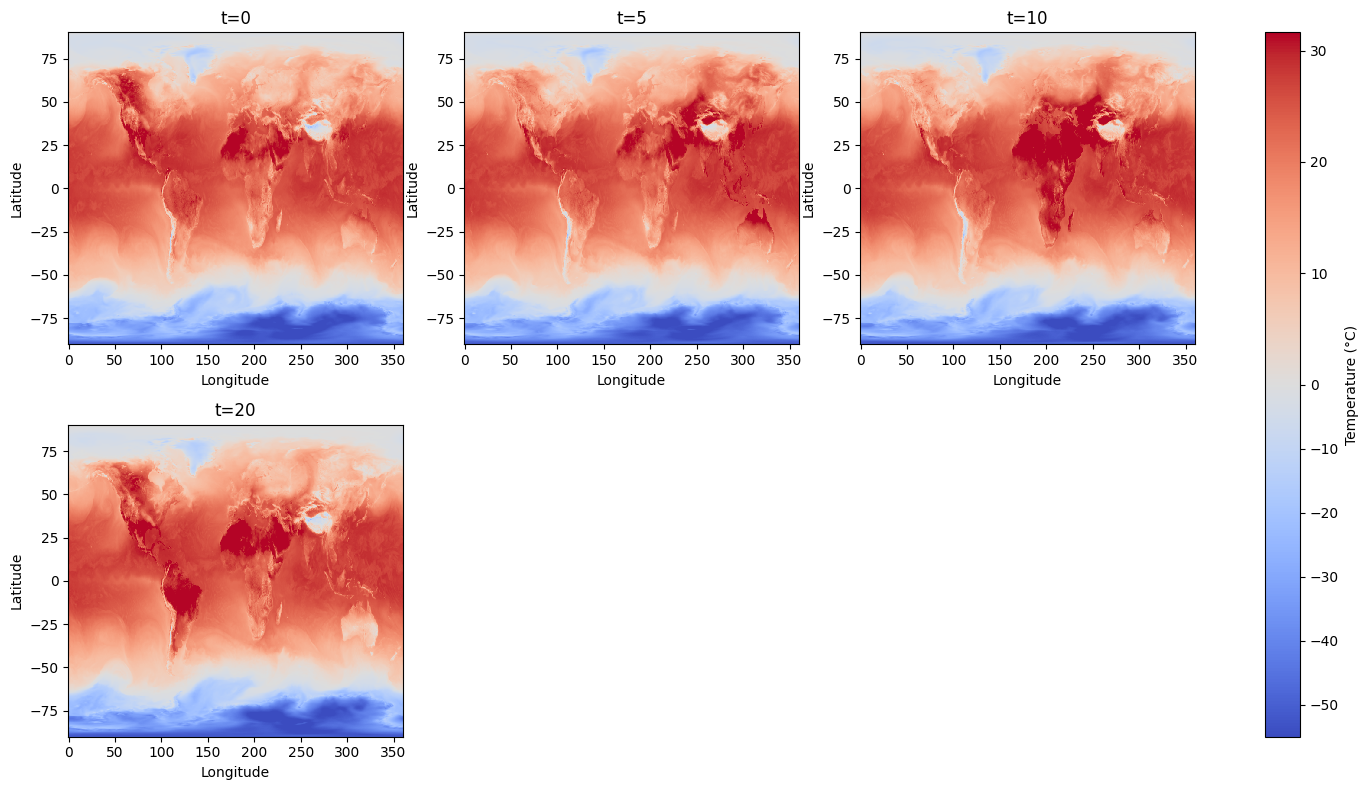

In [14]:
plot_multiple_times("era5_data/temperature_2m/chunk_968.om", timesteps=[0, 5, 10, 20])


In [ ]:
import os
import datetime as dt
import geopandas as gpd
import numpy as np
import s3fs
from omfiles import OmFilePyReader

# ================================================================
# Download ERA5 data
# ================================================================
def download_era5_variable(variable: str, n_days: int, output_dir="era5_data"):
    fs = s3fs.S3FileSystem(anon=True, client_kwargs={'region_name': 'us-west-2'})
    bucket = f"openmeteo/data/copernicus_era5/{variable}/"
    files = [f for f in fs.ls(bucket) if f.endswith(".om")]

    file_infos = []
    for f in files:
        info = fs.info(f)
        mod_time = info["LastModified"]
        file_infos.append((f, mod_time))

    file_infos.sort(key=lambda x: x[1], reverse=True)
    chunks_needed = (n_days // 21) + 1
    selected = file_infos[:chunks_needed]

    var_dir = os.path.join(output_dir, variable)
    os.makedirs(var_dir, exist_ok=True)
    local_paths = []

    for s3_path, mod_time in selected:
        filename = os.path.basename(s3_path)
        local_path = os.path.join(var_dir, filename)
        if not os.path.exists(local_path):
            print(f"Downloading {filename} (last modified {mod_time}) → {var_dir}")
            fs.get(s3_path, local_path)
        else:
            print(f"Already exists: {local_path}")
        local_paths.append(local_path)

    return local_paths

# ================================================================
# Indexing helpers
# ================================================================
def get_chunk_and_index(ts, global_start, chunk_hours=504, base_dir="era5_data/temperature_2m"):
    offset = int((ts - global_start).total_seconds() // 3600)
    chunk_idx = offset // chunk_hours
    idx_in_chunk = offset % chunk_hours
    filepath = os.path.join(base_dir, f"chunk_{chunk_idx}.om")
    return filepath, idx_in_chunk

def get_day_indices(day, global_start, chunk_hours=504, base_dir="era5_data/temperature_2m"):
    if isinstance(day, dt.datetime):
        day = day.date()
    start = dt.datetime.combine(day, dt.time(0, 0))
    indices = []
    for h in range(24):
        ts = start + dt.timedelta(hours=h)
        filepath, idx = get_chunk_and_index(ts, global_start,
                                            chunk_hours=chunk_hours,
                                            base_dir=base_dir)
        indices.append((filepath, idx))
    return indices

# ================================================================
# Interpolation
# ================================================================
def idw_interpolate_series(lat, lon, arr, lats, lons, radius=2, power=2):
    if lon < 0:
        lon += 360
    i = np.abs(lats - lat).argmin()
    j = np.abs(lons - lon).argmin()

    i0, i1 = max(i - radius, 0), min(i + radius, len(lats) - 1)
    j0, j1 = max(j - radius, 0), min(j + radius, len(lons) - 1)

    sub_lats = lats[i0:i1+1]
    sub_lons = lons[j0:j1+1]
    sub_arr = arr[i0:i1+1, j0:j1+1, :]

    grid_lat, grid_lon = np.meshgrid(sub_lats, sub_lons, indexing="ij")
    flat_lat = grid_lat.ravel()
    flat_lon = grid_lon.ravel()
    flat_vals = sub_arr.reshape(-1, sub_arr.shape[-1])

    dists = np.sqrt((flat_lat - lat)**2 + (flat_lon - lon)**2)
    dists[dists == 0] = 1e-6

    weights = 1.0 / (dists**power)
    weights = weights[:, np.newaxis]

    mask = np.isfinite(flat_vals)
    weighted_vals = np.where(mask, flat_vals * weights, 0.0)
    weighted_weights = np.where(mask, weights, 0.0)

    denom = np.sum(weighted_weights, axis=0)
    series = np.sum(weighted_vals, axis=0) / denom
    return series

# ================================================================
# Main workflow with DEBUG prints
# ================================================================
def process_polygons(day, ndays, geojson, variables_list, output_path,
                     output_dir="era5_data", global_start=dt.datetime(1970,1,1,0)):
    gdf = gpd.read_file(geojson)

    # ERA5 grid definition
    lats = np.linspace(-90, 90, 721)
    lons = np.linspace(0, 360 - 0.25, 1440)

    for var in variables_list:
        print(f"=== Processing variable {var} ===")
        var_dir = os.path.join(output_dir, var)
        os.makedirs(var_dir, exist_ok=True)
        download_era5_variable(var, ndays, output_dir)

        for d in range(ndays):
            dday = day + dt.timedelta(days=d)
            day_indices = get_day_indices(dday, global_start, base_dir=var_dir)

            # Group indices per file
            files_needed = {}
            for f, idx in day_indices:
                files_needed.setdefault(f, []).append(idx)

            # Read arrays
            arr_by_file = {}
            for f, idxs in files_needed.items():
                idxs_sorted = sorted(idxs)
                with OmFilePyReader(f) as reader:
                    full_arr = reader[:]  # (721, 1440, 504)
                arr = full_arr[:, :, idxs_sorted]

                # DEBUG
                print(f"[READ] {os.path.basename(f)} idxs={idxs_sorted} "
                      f"→ arr shape={arr.shape}, "
                      f"min={np.nanmin(arr):.3f}, max={np.nanmax(arr):.3f}, "
                      f"valid={np.isfinite(arr).sum()}/{arr.size}")

                arr_by_file[f] = (arr, idxs_sorted)

            # Build day cube
            day_cube = np.full((721, 1440, 24), np.nan)
            for t, (f, idx) in enumerate(day_indices):
                arr, idxs_sorted = arr_by_file[f]
                pos = idxs_sorted.index(idx)
                day_cube[:, :, t] = arr[:, :, pos]

            # DEBUG
            valid_counts = [int(np.isfinite(day_cube[:,:,t]).sum()) for t in range(24)]
            print(f"[DAYCUBE] {var} {dday} valid per hour={valid_counts}")
            if np.any(np.isfinite(day_cube)):
                print(f"[DAYCUBE] min={np.nanmin(day_cube):.3f} max={np.nanmax(day_cube):.3f}")
            else:
                print(f"[DAYCUBE] WARNING: all-NaN")

            # Interpolate per polygon
            values = []
            for pidx, row in gdf.iterrows():
                centroid = row.geometry.centroid
                lat, lon = centroid.y, centroid.x
                series = idw_interpolate_series(lat, lon, day_cube, lats, lons)
                daily_mean = float(np.nanmean(series))
                values.append(daily_mean)

                if pidx == 0 and d == 0:  # DEBUG first poly/day
                    print(f"[POLY0] centroid=({lat:.3f},{lon:.3f}) "
                          f"series first6={series[:6]} "
                          f"mean={daily_mean}")

            gdf[f"{var}_T{d+1}"] = values

    gdf.to_file(output_path, driver="GeoJSON")
    print(f"Saved results → {output_path}")

# ================================================================
# Example usage
# ================================================================
if __name__ == "__main__":
    today = dt.date.today()
    ndays = 2
    geojson = "crop.geojson"
    variables_list = ["temperature_2m", "wind_gusts_10m"]
    output_path = "crop_with_vars.geojson"
    process_polygons(today, ndays, geojson, variables_list, output_path)


=== Processing variable temperature_2m ===
Already exists: era5_data\temperature_2m\chunk_968.om


OSError: The system cannot find the file specified. (os error 2)